# OpenAI Gym (DQN)
https://simoninithomas.github.io/Deep_reinforcement_learning_Course/  
https://medium.freecodecamp.org/an-introduction-to-deep-q-learning-lets-play-doom-54d02d8017d8  
https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682  
https://github.com/yandexdataschool/Practical_RL/blob/master/week4_approx_rl/homework_pytorch.ipynb  
http://maciejjaskowski.github.io/2016/03/09/space-invaders.html  
https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf

## 1. Setup

In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import skimage
import retro
import sys
import tensorflow as tf

from collections import deque

%matplotlib inline

print(f'sys.version: {sys.version}')
print(f'skimage.version: {skimage.__version__}')
print(f'tf.version: {tf.__version__}')
print(f'retro.version: {retro.__version__}')

sys.version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]
skimage.version: 0.14.1
tf.version: 1.11.0
retro.version: 0.6.1.dev25+g9ec2e44


## 2. Look at the SpaceInvaders-Atari2600 env
Steps to follow:
1. Download zip file from http://www.atarimania.com/rom_collection_archive_atari_2600_roms.html
2. Open Roms.rar > ROMS.rar and find Space Invaders (1980) XXXXXX
3. Extract all matches (there are 5 of them) into your destin folder
4. python -m retro.import . (don't forget the point)

In [2]:
env = retro.make('SpaceInvaders-Atari2600')
env.reset()
env.render()
print(f'action_space.size: {env.action_space.n}')

action_space.size: 8


In [3]:
actions = np.identity(env.action_space.n, dtype=int)
for a in actions:
    print(a, ': ', env.get_action_meaning(a))

[1 0 0 0 0 0 0 0] :  ['BUTTON']
[0 1 0 0 0 0 0 0] :  []
[0 0 1 0 0 0 0 0] :  []
[0 0 0 1 0 0 0 0] :  []
[0 0 0 0 1 0 0 0] :  ['UP']
[0 0 0 0 0 1 0 0] :  ['DOWN']
[0 0 0 0 0 0 1 0] :  ['LEFT']
[0 0 0 0 0 0 0 1] :  ['RIGHT']


__I will use just 4 actions: [0, 1, 6, 7] <=> ['BUTTON', '', 'LEFT', 'RIGHT']__

## 3. DQN

### CNN architecture
1. Conv2d(filters=32, kernel_size=8, strides=4, padding='valid', activation=ELU)
2. Conv2d(filters=64, kernel_size=4, strides=2, padding='valid', activation=ELU)  
3. Conv2d(filters=64, kernel_size=3, strides=2, padding='valid', activation=ELU) -> Flatten()  
4. FC(512, activation=ELU)
5. FC(NUM_ACTIONS, activation=Linear)

### Some hyperparameters and constants

In [4]:
# Preprocessing
STACK_SIZE = 4 

# Model
STATE_SHAPE = [110, 84, STACK_SIZE]
ACTION_SIZE = 4 # ['BUTTON', '', 'LEFT', 'RIGHT']
# Hot encoded version of our actions
GENERAL_ACTIONS = np.identity(env.action_space.n, dtype=int)
POSSIBLE_ACTIONS = GENERAL_ACTIONS[[0,1,6,7]]

# Training
NUM_EPISODES = 100
MAX_STEPS_PER_EPISODE = 50_000
BATCH_SIZE = 64
LEARNING_RATE = 2.5e-4
GAMMA = 0.9

# Eps-greedy
EPS_START = 1
EPS_END = 1e-2
EPS_DECAY_RATE = 2e-5

# Memory for Experience Replay
MEMORY_SIZE = 50_000
PRETRAIN_LENGTH = BATCH_SIZE

# Fixed Q-targets
Q_TARGET_UPDATE_FREQ = 10_000

# Save the model every 10 episodes
SAVE_EVERY = 10
SAVE_PATH = './checkpoints'

### Preprocessing functions

In [5]:
def preprocess_frame(rgb_frame):
    # gray
    gray_frame = skimage.color.rgb2gray(rgb_frame)
    
    # crop
    cropped_frame = gray_frame[8:-12, 4:-12]
    
    # norm
    norm_frame = cropped_frame / 255.
    
    # resize
    preprocessed_frame = skimage.transform.resize(norm_frame, [110, 84], 
                                                  mode='constant',
                                                  anti_aliasing=False)
    
    # preprocessed
    return preprocessed_frame

def stack_frames(stacked_frames, state, is_new_episode):
    frame = preprocess_frame(state)
    
    if is_new_episode:
        stacked_frames = deque(maxlen=STACK_SIZE)
        for _ in range(STACK_SIZE):
            stacked_frames.append(frame)
    else:
        stacked_frames.append(frame)
    
    stacked_states = np.moveaxis(stacked_frames, 0, -1)
    
    # stacked_states.shape: [110, 84, 4]
    # stacked_frames.shape: [4, 110, 84]
    return stacked_states, stacked_frames

### Memory class (for Experience Replay)

In [6]:
class Memory:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        indices = np.random.choice(np.arange(buffer_size),
                                   size=batch_size,
                                   replace=False)
        experiences_batch = [self.buffer[idx] for idx in indices]
        return experiences_batch

#### Pre-populate memory by taking random actions and storing each experience (state, action, reward, next_state, done)

In [7]:
def get_pre_populated_memory(env):
    memory = Memory(max_size=MEMORY_SIZE)
    stacked_frames = []
    state = None

    for step in range(PRETRAIN_LENGTH):
        if step == 0:
            state = env.reset()
            state, stacked_frames = stack_frames(stacked_frames, state,
                                                 is_new_episode=True)

        # random action
        action_idx = np.random.randint(ACTION_SIZE)
        action = POSSIBLE_ACTIONS[action_idx]
        
        # next state
        next_state, reward, done, _ = env.step(action)
        next_state, stacked_frames = stack_frames(stacked_frames, next_state,
                                                  is_new_episode=False)

        if done:
            # the end of episode (next_state = 0)
            next_state = np.zeros(STATE_SHAPE)
            next_state, stacked_frames = stack_frames(stacked_frames, next_state,
                                                      is_new_episode=False)

            # add experience to memory
            memory.add((state, action_idx, reward, next_state, done))

            # start a new episode
            state = env.reset()
            state, stacked_frames = stack_frames(stacked_frames, state,
                                                 is_new_episode=True)
        else:
            # add experience to memory
            memory.add((state, action_idx, reward, next_state, done))
            state = next_state
    
    return memory

### DQN class

In [8]:
class DQN:
    def __init__(self, state_shape, action_size, dqn_name='DQN'):
        self.state_shape = state_shape
        self.action_size = action_size
        
        with tf.variable_scope(dqn_name):
            self.input_ph = tf.placeholder(tf.float32,
                                           [None, *self.state_shape], name='input')
            self.action_indices_ph = tf.placeholder(tf.uint8,
                                                    [None], name='action')
            self.Q_target_ph = tf.placeholder(tf.float32,
                                             [None], name='target')
            self.learning_rate_ph = tf.placeholder(tf.float32,
                                                   (), name='learning_rate')
            
            self.actions_one_hot = tf.one_hot(self.action_indices_ph, self.action_size)
            xavier_init = tf.glorot_uniform_initializer()
            
            # l1
            self.conv1 = tf.layers.conv2d(self.input_ph,
                                          filters=32, kernel_size=8,
                                          strides=4, padding='valid',
                                          kernel_initializer=xavier_init,
                                          activation=tf.nn.elu, name='conv1')
            
            # l2
            self.conv2 = tf.layers.conv2d(self.conv1,
                                          filters=64, kernel_size=4,
                                          strides=2, padding='valid',
                                          kernel_initializer=xavier_init,
                                          activation=tf.nn.elu, name='conv2')
            
            # l3
            self.conv3 = tf.layers.conv2d(self.conv2,
                                          filters=64, kernel_size=3,
                                          strides=2, padding='valid',
                                          kernel_initializer=xavier_init,
                                          activation=tf.nn.elu, name='conv3')
            self.flatten3 = tf.layers.flatten(self.conv3)
            
            # l4
            self.fc4 = tf.layers.dense(self.flatten3,
                                       units=512,
                                       kernel_initializer=xavier_init,
                                       activation=tf.nn.elu, name='fc4')
            
            # l5
            self.output = tf.layers.dense(self.fc4,
                                          units=self.action_size,
                                          kernel_initializer=xavier_init,
                                          activation=None, name='output')
            
            # prediction
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_one_hot), axis=1)
            
            with tf.name_scope('loss'):
                self.loss = tf.reduce_mean(tf.square(self.Q_target_ph - self.Q))
            
            with tf.name_scope('optimization'):
                self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate_ph)
                self.optimization_step = self.optimizer.minimize(self.loss)

### Instantiate DQNs: DQN and TargetDQN

In [9]:
tf.reset_default_graph()

dqn = DQN(state_shape=STATE_SHAPE, action_size=ACTION_SIZE, dqn_name='DQN')
dqn_target = DQN(state_shape=STATE_SHAPE, action_size=ACTION_SIZE, dqn_name='DQNTarget')

### Helper function to copy DQN parameters to DQNTarget

In [10]:
def update_dqn_target():
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'DQN')
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'DQNTarget')
    
    op_holder = []
    for from_var, to_var in zip(from_vars, to_vars):
        op_holder.append(to_var.assign(from_var))
        
    return op_holder

### DQN (training algorithm)

In [11]:
def eps_greedy(sess, state, eps_decay_step):
    # eps: exploration probability
    eps = EPS_END + (EPS_START - EPS_END) * np.exp(-EPS_DECAY_RATE * eps_decay_step)
    
    if np.random.rand() < eps:
        # exploration with eps probability
        action_idx = np.random.randint(ACTION_SIZE)
    else:
        # exploitation with (1 - eps) probability
        Q = sess.run(dqn.output,
                     feed_dict={
                         dqn.input_ph: state.reshape(1, *STATE_SHAPE)
                     })
        
        action_idx = np.argmax(Q)

    return action_idx, eps

In [12]:
def dqn_training(dqn, dqn_target,
                 num_episodes=NUM_EPISODES, 
                 max_steps_per_episode=MAX_STEPS_PER_EPISODE, 
                 batch_size=BATCH_SIZE,
                 learning_rate=LEARNING_RATE):
    
    # memory for experience replay
    memory = get_pre_populated_memory(env)
    
    # update dqn target op
    update_dqn_target_op = update_dqn_target()    
    
    # to save some ckpts
    saver = tf.train.Saver(max_to_keep=30)
    
    with tf.Session() as sess:
        # init tf variables
        sess.run(tf.global_variables_initializer())
        
        # init dqn_target with the same params as dqn
        sess.run(update_dqn_target_op)
        
        step = 0
        best_rewards = [0 for _ in range(2)]
        best_episodes = [[] for _ in range(2)]
        iters_per_episode = []
        reward_per_episode = []
        loss_per_iter = []
        
        for episode in range(1, num_episodes + 1):
            episode_step = 0
            done = False
            stacked_frames = []
            episode_rewards = []
            episode_states = []
            
            # new episode
            state = env.reset()
            episode_states.append(state.copy())
            state, stacked_frames = stack_frames(stacked_frames, state,
                                                 is_new_episode=True)
            
            
            while (not done) and (episode_step < max_steps_per_episode):
                episode_step += 1
                step += 1
                
                action_idx, eps = eps_greedy(sess, state, step)
                action = POSSIBLE_ACTIONS[action_idx]
                next_state, reward, done, _ = env.step(action)
                episode_rewards.append(reward)
                episode_states.append(next_state.copy())
                
                if done:
                    # the end of episode (next_state = 0)
                    next_state = np.zeros(STATE_SHAPE)
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state,
                                                              is_new_episode=False)
                    # add experience to memory
                    memory.add((state, action_idx, reward, next_state, done))
                    
                    total_reward = np.sum(episode_rewards)
                    reward_per_episode.append(total_reward)
                    iters_per_episode.append(episode_step)
                    
                    print(f'Episode: {episode}, '
                          f'Total reward: {total_reward}, '
                          f'Epsilon: {eps}')
                else:
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state,
                                                              is_new_episode=False)
                    # add experience to memory
                    memory.add((state, action_idx, reward, next_state, done))
                    
                    state = next_state
                    
                ### learning part ###
                # sample a random batch of experiences from memory
                batch = memory.sample(batch_size)
                batch_states = np.array([experience[0] for experience in batch], ndmin=3)
                batch_action_indices = np.array([experience[1] for experience in batch])
                batch_rewards = np.array([experience[2] for experience in batch])
                batch_next_states = np.array([experience[3] for experience in batch], ndmin=3)
                batch_dones = np.array([experience[4] for experience in batch])

                # if the episode ends at next_state:
                #     Q_target(state) = reward
                # else:
                #     Q_target(state) = reward + gamma * argmax(a){Q_next_state}
                Q_batch_next_state = sess.run(dqn_target.output,
                                              feed_dict={
                                                  dqn_target.input_ph: batch_next_states
                                              })
                
                # terminal states => Q value = 0
                Q_batch_next_state[batch_dones, :] = 0
                
                Q_target = batch_rewards + GAMMA * np.max(Q_batch_next_state, axis=1)
                
                loss, _ = sess.run([dqn.loss, dqn.optimization_step],
                                   feed_dict={
                                       dqn.input_ph: batch_states,
                                       dqn.action_indices_ph: batch_action_indices,
                                       dqn.Q_target_ph: Q_target,
                                       dqn.learning_rate_ph: learning_rate
                                   })
                
                if step % Q_TARGET_UPDATE_FREQ == 0:
                    print('Update parameters of DQNTarget')
                    sess.run(update_dqn_target_op)
                
                loss_per_iter.append(loss)
            
            # keep 2 train episodes with high reward
            min_pos = np.argmin(best_rewards)
            max_pos = np.argmax(best_rewards)
            min_reward = best_rewards[min_pos]
            max_reward = best_rewards[max_pos]
            cur_reward = reward_per_episode[-1]
            
            if cur_reward > max_reward:
                best_episodes[min_pos] = best_episodes[max_pos]
                best_rewards[min_pos] = best_rewards[max_pos]
                best_episodes[max_pos] = [episode, cur_reward, episode_states]
                best_rewards[max_pos] = cur_reward
            elif cur_reward > min_reward:
                best_episodes[min_pos] = [episode, cur_reward, episode_states]
                best_rewards[min_pos] = cur_reward
            
            if (episode == 1) or (episode % SAVE_EVERY == 0):
                saver.save(sess, f'{SAVE_PATH}/model_episode_{episode}.ckpt')
                print('Model saved')
                
    return iters_per_episode, reward_per_episode, loss_per_iter, best_episodes

In [13]:
%%time
!rm -rf $SAVE_PATH
train_stats = dqn_training(dqn, dqn_target, num_episodes=NUM_EPISODES)

Episode: 1, Total reward: 490.0, Epsilon: 0.944063985768051
Model saved
Episode: 2, Total reward: 210.0, Epsilon: 0.900929182265611
Episode: 3, Total reward: 805.0, Epsilon: 0.8277077043735628
Update parameters of DQNTarget
Episode: 4, Total reward: 155.0, Epsilon: 0.794137935590781
Episode: 5, Total reward: 210.0, Epsilon: 0.7625481212840453
Episode: 6, Total reward: 90.0, Epsilon: 0.7359092036267341
Episode: 7, Total reward: 155.0, Epsilon: 0.7099332288444264
Episode: 8, Total reward: 110.0, Epsilon: 0.6907702945320269
Update parameters of DQNTarget
Episode: 9, Total reward: 145.0, Epsilon: 0.6677237057907982
Episode: 10, Total reward: 190.0, Epsilon: 0.6346209233759206
Model saved
Episode: 11, Total reward: 240.0, Epsilon: 0.6055854927417487
Episode: 12, Total reward: 20.0, Epsilon: 0.5891172394247879
Episode: 13, Total reward: 115.0, Epsilon: 0.5723165475125561
Update parameters of DQNTarget
Episode: 14, Total reward: 435.0, Epsilon: 0.5396227407209141
Episode: 15, Total reward: 21

#### Training stats

In [14]:
iters_per_episode, reward_per_episode, loss_per_iter, best_episodes = train_stats

#### Save episodes with high reward during training phase (max 2)

In [ ]:
!rm -rf ./train_stats
!mkdir ./train_stats

In [16]:
%%time
for episode, reward, frames in best_episodes:
    np.save(f'./train_stats/train_episode_{episode}_reward_{int(reward)}.npy', frames)

CPU times: user 452 ms, sys: 2.33 s, total: 2.78 s
Wall time: 29 s


#### Some plots

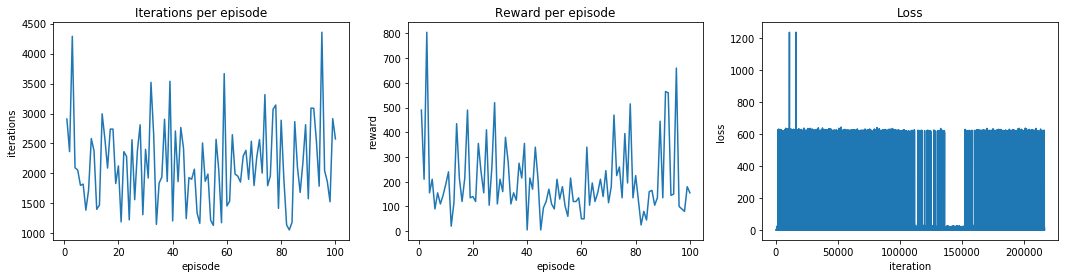

In [17]:
episode_range = np.arange(len(iters_per_episode)) + 1
iter_range = np.arange(len(loss_per_iter)) + 1

plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.title('Iterations per episode')
plt.plot(episode_range, iters_per_episode)
plt.ylabel('iterations')
plt.xlabel('episode')

plt.subplot(1, 3, 2)
plt.title('Reward per episode')
plt.plot(episode_range, reward_per_episode)
plt.ylabel('reward')
plt.xlabel('episode')

plt.subplot(1, 3, 3)
plt.title('Loss')
plt.plot(iter_range, loss_per_iter)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.show()

### Test and watch how the agent plays SpaceInvaders-Atari2600

In [18]:
def test(dqn, env, episode=NUM_EPISODES):
    frames = []
    with tf.Session() as sess:
        # load the model
        tf.train.Saver().restore(sess, SAVE_PATH + f'/model_episode_{episode}.ckpt')
        
        step = 0
        total_reward = 0
        done = False
        stacked_frames = []
        
        state = env.reset()
        frames.append(state)
        state, stacked_frames = stack_frames(stacked_frames, state, 
                                             is_new_episode=True)
        env.render()
        
        while not done:
            state = state.reshape([1, *STATE_SHAPE])
            Q = sess.run(dqn.output,
                         feed_dict={
                             dqn.input_ph: state
                         })
            action_idx = np.argmax(Q)
            action = POSSIBLE_ACTIONS[action_idx]
            
            next_state, reward, done, _ = env.step(action)
            frames.append(next_state.copy())
            next_state, stacked_frames = stack_frames(stacked_frames, next_state,
                                                      is_new_episode=False)
            state = next_state
            env.render()
            
            step += 1
            total_reward += reward
        
        print(f'Steps: {step}, total_reward: {total_reward}')
    return frames

In [19]:
frames = test(dqn, env)
#env.close()

INFO:tensorflow:Restoring parameters from ./checkpoints/model_episode_100.ckpt
Steps: 3448, total_reward: 170.0
